In [1]:
import pandas as pd 
df=pd.read_csv('resumes_preprocessed.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'resumes_preprocessed.csv'

In [5]:
import sys
!{sys.executable} -m pip install geoopt Levenshtein fuzzywuzzy unidecode

In [ ]:
# ============================================================
# JAMES + ESCO + Career Trajectories (RU + EN)
# Yamashita et al., 2023 — FULL PIPELINE
# ============================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from unidecode import unidecode
import geoopt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ============================================================
# 1. LOAD DATA
# ============================================================

DATA_PATH = "resumes_preprocessed.csv"
ESCO_PATH = r"D:\for_vs\ESCO dataset - v1.2.1 - classification - en - csv\occupations_en.csv"


df = pd.read_csv(DATA_PATH)

esco = pd.read_csv(ESCO_PATH)
esco = esco[['conceptUri', 'preferredLabel']].dropna()
esco.columns = ['uri', 'label']
esco['label_norm'] = esco['label'].str.lower()
ESCO_LABELS = esco['label_norm'].tolist()
NUM_CLASSES = len(ESCO_LABELS)

print(f"Loaded ESCO occupations: {NUM_CLASSES}")

# ============================================================
# 2. TEXT NORMALIZATION
# ============================================================

def normalize_text(x):
    x = str(x).lower()
    x = unidecode(x)
    return x.strip()

# ============================================================
# 3. MULTILINGUAL SBERT (Xᵇ)
# ============================================================

sbert = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
)

def encode_sbert(texts, batch=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="SBERT"):
        embs.append(
            sbert.encode(
                texts[i:i+batch],
                normalize_embeddings=True
            )
        )
    return np.vstack(embs)

ESCO_SBERT = encode_sbert(ESCO_LABELS)

# ============================================================
# 4. SYNTACTIC EMBEDDING (Xˢ)
# ============================================================

vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(3,5))
ESCO_CHAR = vectorizer.fit_transform([normalize_text(x) for x in ESCO_LABELS])

def syntactic_embed(texts):
    texts = [normalize_text(x) for x in texts]
    X = vectorizer.transform(texts)
    return cosine_similarity(X, ESCO_CHAR)

# ============================================================
# 5. BUILD CAREER TRANSITION GRAPH
# ============================================================

JOB_COLS = [
    "job_4_position",
    "job_3_position",
    "job_2_position",
    "job_1_position",
    "title"
]

def build_transition_graph(df):
    G = nx.DiGraph()
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Career Graph"):
        seq = [row[c] for c in JOB_COLS if pd.notna(row[c])]
        seq = [normalize_text(x) for x in seq]
        for a, b in zip(seq[:-1], seq[1:]):
            G.add_edge(a, b)
    return G

career_graph = build_transition_graph(df)

# ============================================================
# 6. POINCARÉ EMBEDDING (Xʰ)
# ============================================================

def poincare_embed(G, dim=128, epochs=30):
    nodes = list(G.nodes())
    idx = {n:i for i,n in enumerate(nodes)}
    edges = [(idx[u], idx[v]) for u,v in G.edges()]

    ball = geoopt.PoincareBall()
    emb = geoopt.ManifoldParameter(
        torch.randn(len(nodes), dim) * 1e-3,
        manifold=ball
    )

    opt = torch.optim.Adam([emb], lr=1e-2)

    for _ in tqdm(range(epochs), desc="Poincaré"):
        loss = 0
        for u,v in edges:
            loss += ball.dist(emb[u], emb[v])
        opt.zero_grad()
        loss.backward()
        opt.step()

    return emb.detach().cpu().numpy(), idx

GRAPH_EMB, GRAPH_IDX = poincare_embed(career_graph)

# ============================================================
# 7. JAMES MODEL
# ============================================================

class NeuralNOT(nn.Module):
    def __init__(self, d): super().__init__(); self.fc = nn.Linear(d,d)
    def forward(self,x): return torch.tanh(self.fc(x))

class NeuralOR(nn.Module):
    def __init__(self, d): super().__init__(); self.fc = nn.Linear(2*d,d)
    def forward(self,x,y): return torch.tanh(self.fc(torch.cat([x,y],-1)))

class Reasoning(nn.Module):
    def __init__(self,d):
        super().__init__()
        self.NOT = NeuralNOT(d)
        self.OR = NeuralOR(d)
        self.T = nn.Parameter(torch.randn(d))
        self.F = nn.Parameter(torch.randn(d))

    def forward(self,X):
        out = self.NOT(X[:,0:1])
        for i in range(1,X.shape[1]):
            out = self.OR(out, self.NOT(X[:,i:i+1]))
        return out.squeeze(1)

class CoAttention(nn.Module):
    def __init__(self, dh, db, ds):
        super().__init__()
        self.hb = nn.Linear(dh, db, False)
        self.hs = nn.Linear(dh, ds, False)
        self.bs = nn.Linear(db, ds, False)

    def forward(self,h,b,s):
        Ahb = torch.tanh(self.hb(h) @ b.T)
        Ahs = torch.tanh(self.hs(h) @ s.T)
        Abs = torch.tanh(self.bs(b) @ s.T)
        return (
            F.softmax(h + Ahb@b + Ahs@s, -1),
            F.softmax(b + Ahb.T@h + Abs@s, -1),
            F.softmax(s + Ahs.T@h + Abs.T@b, -1)
        )

class JAMES(nn.Module):
    def __init__(self, dh, db, ds, C):
        super().__init__()
        self.coatt = CoAttention(dh,db,ds)
        self.rb = Reasoning(C)
        self.rs = Reasoning(C)
        self.fc = nn.Linear(dh+db+ds+2*C, C)

    def forward(self,h,b,s):
        h,b,s = self.coatt(h,b,s)
        rb = self.rb(b)
        rs = self.rs(s)
        return F.softmax(self.fc(torch.cat([h,b,s,rb,rs],-1)), -1)

# ============================================================
# 8. NORMALIZATION (INFERENCE)
# ============================================================

def normalize_titles(titles):
    titles_norm = [normalize_text(x) for x in titles]

    Xb = encode_sbert(titles_norm)
    Xs = syntactic_embed(titles_norm)

    scores = 0.7 * (Xb @ ESCO_SBERT.T) + 0.3 * Xs
    idx = scores.argmax(1)

    return [ESCO_LABELS[i] for i in idx]

# ============================================================
# 9. APPLY TO DATASET
# ============================================================

for col in ["title"] + JOB_COLS[:-1]:
    print(f"Normalizing {col}")
    df[col + "_esco"] = normalize_titles(df[col].fillna("").tolist())

# ============================================================
# 10. CAREER TRAJECTORIES IN ESCO SPACE
# ============================================================

def build_esco_trajectory(row):
    return [
        row.get("job_4_position_esco"),
        row.get("job_3_position_esco"),
        row.get("job_2_position_esco"),
        row.get("job_1_position_esco"),
        row.get("title_esco")
    ]

df["esco_trajectory"] = df.apply(build_esco_trajectory, axis=1)

# ============================================================
# 11. SAMPLE OUTPUT
# ============================================================

print("\n" + "="*80)
print("📋 RANDOM SAMPLES: ORIGINAL → ESCO")
print("="*80)

sample = df.sample(15)
for _, r in sample.iterrows():
    print(f"{r['title']}  →  {r['title_esco']}")

# ============================================================
# DONE

# ============================================================

print("\nPipeline finished successfully.")


Loaded ESCO occupations: 3043


Poincaré: 100%|██████████| 30/30 [4:30:13<00:00, 540.46s/it]  


Normalizing title


SBERT: 100%|██████████| 408/408 [09:32<00:00,  1.40s/it]


Normalizing job_4_position


SBERT: 100%|██████████| 408/408 [08:05<00:00,  1.19s/it]


Normalizing job_3_position


SBERT: 100%|██████████| 408/408 [08:40<00:00,  1.28s/it]


Normalizing job_2_position


SBERT: 100%|██████████| 408/408 [09:20<00:00,  1.37s/it]


Normalizing job_1_position


SBERT: 100%|██████████| 408/408 [09:21<00:00,  1.38s/it]



📋 RANDOM SAMPLES: ORIGINAL → ESCO
Портфельный риск аналитик  →  credit risk analyst
Разработчик Lotus Domino  →  sommelier
Аналитик данных  →  business analyst
Аналитик  →  business analyst
Industrial Engineering/ Lean Manufacturing/ Work Process Improvement  →  manufacturing engineer
Дизайнер  →  industrial designer
Программист-разработчик 1C  →  venue programmer
Unity Developer  →  user interface developer
Бизнес-аналитик  →  business analyst
Sound Designer / Саунд дизайнер  →  sound designer
PHP developer  →  web developer
Дизайнер, веб-дизайнер, UX/UI  →  web designer
Специалист технической поддержки / Системный администратор  →  ict system administrator
Системный администратор (удалённо)  →  ict system administrator
Главный специалист/Эксперт (СК/ТН,QA/QC), Начальник участка/отдела по строительному контролю  →  répétiteur

Pipeline finished successfully.


In [13]:
OUTPUT_PATH = "resumes_with_esco.csv"
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8-sig")
print(f"Saved: {OUTPUT_PATH}")


Saved: resumes_with_esco.csv


In [16]:
def build_esco_transition_graph(df):
    G = nx.DiGraph()

    for _, row in tqdm(df.iterrows(), total=len(df), desc="ESCO Graph"):
        traj = row["esco_trajectory"]
        traj = [t for t in traj if pd.notna(t)]

        for a, b in zip(traj[:-1], traj[1:]):
            if G.has_edge(a, b):
                G[a][b]["weight"] += 1
            else:
                G.add_edge(a, b, weight=1)
    return G

esco_graph = build_esco_transition_graph(df)


ESCO Graph: 100%|██████████| 26052/26052 [00:00<00:00, 35998.23it/s]


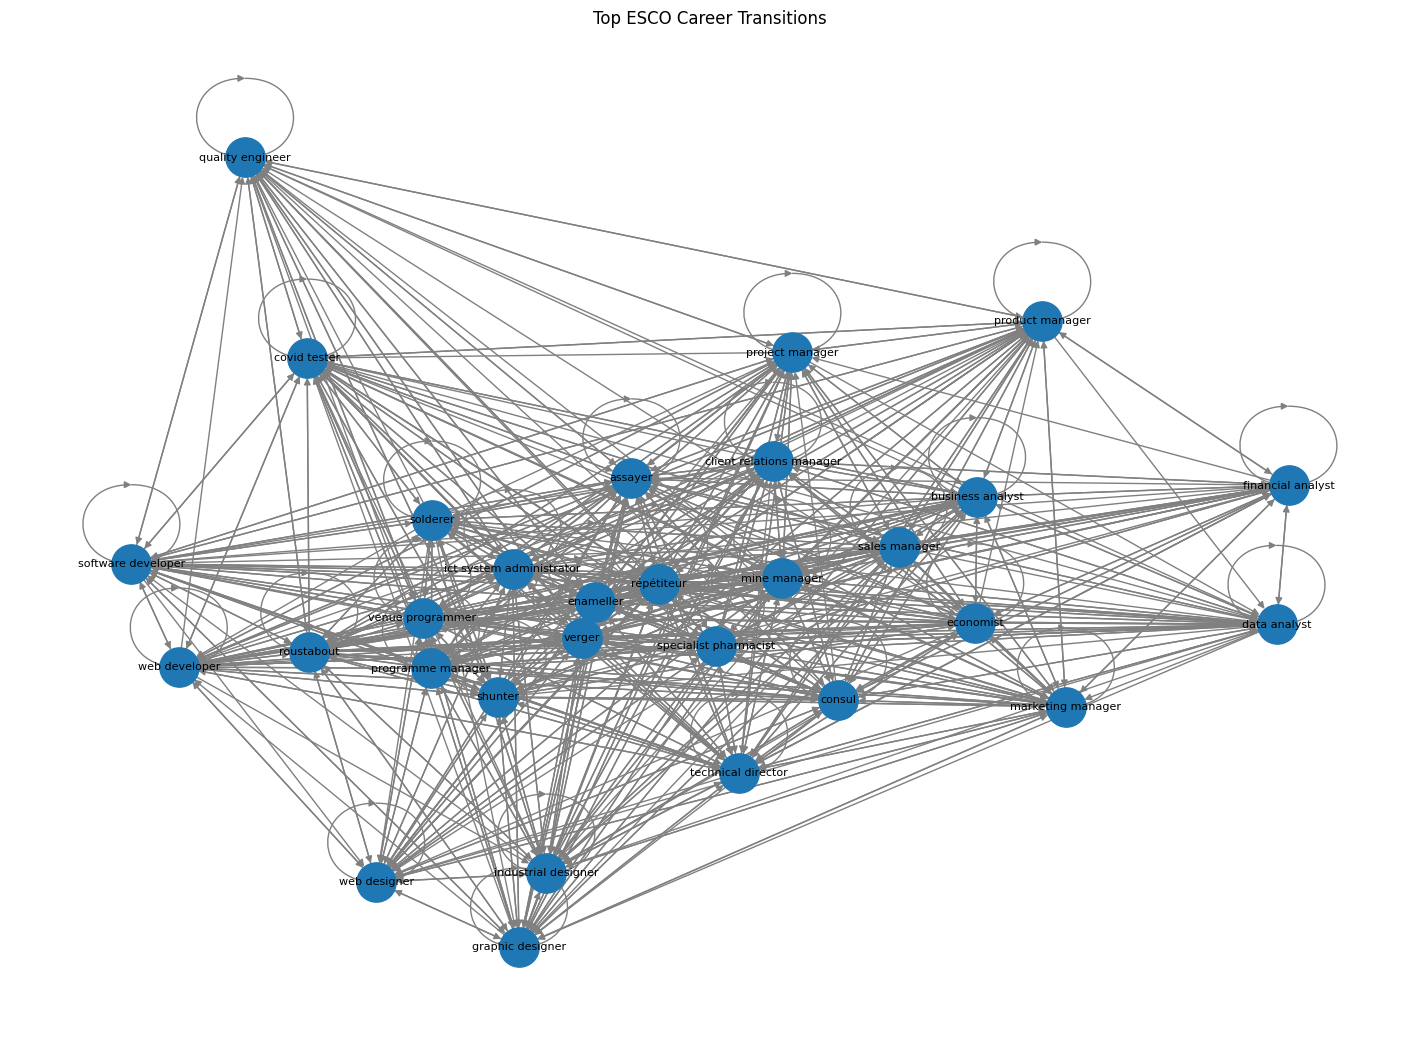

In [17]:
import matplotlib.pyplot as plt

top_nodes = sorted(
    esco_graph.nodes(),
    key=lambda x: esco_graph.in_degree(x),
    reverse=True
)[:30]

sub = esco_graph.subgraph(top_nodes)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(sub, k=0.5)
nx.draw(
    sub,
    pos,
    with_labels=True,
    node_size=800,
    font_size=8,
    edge_color="gray"
)
plt.title("Top ESCO Career Transitions")
plt.show()


In [18]:
"""
JAMES - Training, Evaluation & Inference (Part 2)
Continue from main implementation
"""
"""
JAMES: Job Title Normalization - CORRECT Implementation
Following Yamashita et al., 2023 EXACTLY with Russian adaptation

KEY FIXES:
1. Proper training loop with ground truth labels
2. Correct Poincaré loss (contrastive with negative sampling)
3. Exact co-attention implementation from paper
4. Multi-stage training strategy for Russian data
"""

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from unidecode import unidecode
import geoopt
from collections import Counter
import re

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# ============================================================
# STEP 1: LOAD DATA
# ============================================================

DATA_PATH = "resumes_preprocessed.csv"
ESCO_PATH = r"D:\for_vs\ESCO dataset - v1.2.1 - classification - en - csv\occupations_en.csv"

print("\n" + "="*80)
print("STEP 1: Loading Data")
print("="*80)

df = pd.read_csv(DATA_PATH)
print(f"Loaded {len(df)} resumes")

esco = pd.read_csv(ESCO_PATH)
esco = esco[['conceptUri', 'preferredLabel', 'altLabels']].dropna(subset=['preferredLabel'])
esco['label_clean'] = esco['preferredLabel'].str.lower().str.strip()

# Remove duplicates
esco = esco.drop_duplicates(subset=['label_clean'])

ESCO_LABELS = esco['label_clean'].tolist()
ESCO_DICT = {label: idx for idx, label in enumerate(ESCO_LABELS)}
NUM_CLASSES = len(ESCO_LABELS)

print(f"ESCO taxonomy: {NUM_CLASSES} unique occupations")

# ============================================================
# STEP 2: TEXT NORMALIZATION
# ============================================================

def normalize_text(text):
    """Clean and normalize job title"""
    if pd.isna(text):
        return ""
    text = str(text).lower().strip()
    # Remove special chars but keep spaces and hyphens
    text = re.sub(r'[^\w\s\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# ============================================================
# STEP 3: EXTRACT ALL JOB TITLES
# ============================================================

print("\n" + "="*80)
print("STEP 2: Extracting Job Titles")
print("="*80)

JOB_COLS = ['title', 'job_1_position', 'job_2_position', 'job_3_position', 'job_4_position']

all_titles = []
title_sources = {}  # Track where each title came from

for col in JOB_COLS:
    titles = df[col].dropna().astype(str).tolist()
    for t in titles:
        t_norm = normalize_text(t)
        if t_norm and len(t_norm) > 2:
            all_titles.append(t_norm)
            if t_norm not in title_sources:
                title_sources[t_norm] = []
            title_sources[t_norm].append(col)

title_counter = Counter(all_titles)
unique_titles = list(title_counter.keys())

print(f"Total job titles: {len(all_titles)}")
print(f"Unique job titles: {len(unique_titles)}")
print(f"Top 5 most common: {title_counter.most_common(5)}")

# ============================================================
# STEP 4: CREATE GROUND TRUTH LABELS (WEAK SUPERVISION)
# ============================================================

print("\n" + "="*80)
print("STEP 3: Creating Ground Truth Labels (Weak Supervision)")
print("="*80)

# Strategy for Russian titles:
# 1. Try exact match with ESCO
# 2. Try TF-IDF + cosine similarity
# 3. Use SBERT similarity as final fallback

def create_ground_truth_labels(titles, esco_labels, threshold=0.6):
    """
    Create weak supervision labels for training
    Returns: dict {title: (esco_label, confidence)}
    """
    
    # Pre-compute ESCO embeddings
    print("Computing ESCO SBERT embeddings...")
    sbert = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
    esco_embs = sbert.encode(esco_labels, show_progress_bar=True, normalize_embeddings=True)
    
    # TF-IDF for character-level matching
    print("Building TF-IDF vectorizer...")
    tfidf = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), max_features=10000)
    esco_tfidf = tfidf.fit_transform(esco_labels)
    
    labels_dict = {}
    high_conf_count = 0
    
    print("Matching titles to ESCO...")
    for title in tqdm(titles):
        # Method 1: Exact match
        if title in esco_labels:
            labels_dict[title] = (title, 1.0)
            high_conf_count += 1
            continue
        
        # Method 2: TF-IDF similarity
        title_tfidf = tfidf.transform([title])
        tfidf_sims = cosine_similarity(title_tfidf, esco_tfidf)[0]
        best_tfidf_idx = np.argmax(tfidf_sims)
        best_tfidf_score = tfidf_sims[best_tfidf_idx]
        
        # Method 3: SBERT similarity
        title_emb = sbert.encode([title], normalize_embeddings=True)
        sbert_sims = cosine_similarity(title_emb, esco_embs)[0]
        best_sbert_idx = np.argmax(sbert_sims)
        best_sbert_score = sbert_sims[best_sbert_idx]
        
        # Combine scores (weighted)
        combined_scores = 0.4 * tfidf_sims + 0.6 * sbert_sims
        best_idx = np.argmax(combined_scores)
        best_score = combined_scores[best_idx]
        
        if best_score >= threshold:
            labels_dict[title] = (esco_labels[best_idx], float(best_score))
            if best_score >= 0.8:
                high_conf_count += 1
        else:
            # Use best match anyway but mark low confidence
            labels_dict[title] = (esco_labels[best_idx], float(best_score))
    
    print(f"✓ Labeled {len(labels_dict)} titles")
    print(f"✓ High confidence (>0.8): {high_conf_count} ({100*high_conf_count/len(titles):.1f}%)")
    
    return labels_dict, esco_embs, tfidf, esco_tfidf

gt_labels, ESCO_SBERT, TFIDF_VEC, ESCO_TFIDF = create_ground_truth_labels(
    unique_titles, ESCO_LABELS, threshold=0.5
)

# ============================================================
# STEP 5: BUILD CAREER TRANSITION GRAPH
# ============================================================

print("\n" + "="*80)
print("STEP 4: Building Career Transition Graph")
print("="*80)

def build_transition_graph(df, job_cols):
    """Build directed graph from job sequences (newer -> older)"""
    G = nx.DiGraph()
    
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building graph"):
        # Get job sequence (chronological order: oldest to newest)
        jobs = []
        for col in reversed(job_cols):  # job_4 -> job_3 -> job_2 -> job_1 -> title
            if pd.notna(row.get(col)):
                job_norm = normalize_text(row[col])
                if job_norm and len(job_norm) > 2:
                    jobs.append(job_norm)
        
        # Add edges (from older to newer job)
        for i in range(len(jobs) - 1):
            # Edge from current job to next job (career progression)
            if G.has_edge(jobs[i], jobs[i+1]):
                G[jobs[i]][jobs[i+1]]['weight'] += 1
            else:
                G.add_edge(jobs[i], jobs[i+1], weight=1)
    
    print(f"✓ Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    
    # Normalize weights
    total_weight = sum([d['weight'] for u, v, d in G.edges(data=True)])
    for u, v, d in G.edges(data=True):
        d['weight_norm'] = d['weight'] / total_weight
    
    return G

career_graph = build_transition_graph(df, JOB_COLS)

# ============================================================
# STEP 6: HYPERBOLIC GRAPH EMBEDDINGS (CORRECT VERSION)
# ============================================================

print("\n" + "="*80)
print("STEP 5: Training Hyperbolic Graph Embeddings")
print("="*80)

def train_poincare_embeddings(graph, dim=128, epochs=50, lr=0.01, neg_samples=10):
    """
    Train Poincaré embeddings with CORRECT contrastive loss
    """
    nodes = list(graph.nodes())
    node2idx = {n: i for i, n in enumerate(nodes)}
    idx2node = {i: n for n, i in node2idx.items()}
    
    # Prepare edges with weights
    edges = []
    weights = []
    for u, v, data in graph.edges(data=True):
        if u in node2idx and v in node2idx:
            edges.append((node2idx[u], node2idx[v]))
            weights.append(data.get('weight_norm', 1.0))
    
    edges = torch.LongTensor(edges).to(DEVICE)
    weights = torch.FloatTensor(weights).to(DEVICE)
    
    # Initialize Poincaré embeddings
    ball = geoopt.PoincareBall()
    embeddings = geoopt.ManifoldParameter(
        torch.randn(len(nodes), dim, device=DEVICE) * 0.001,
        manifold=ball
    )
    
    optimizer = geoopt.optim.RiemannianAdam([embeddings], lr=lr)
    
    print(f"Training on {len(edges)} edges, {len(nodes)} nodes")
    
    for epoch in tqdm(range(epochs), desc="Training Poincaré"):
        optimizer.zero_grad()
        
        # Positive pairs
        u_emb = embeddings[edges[:, 0]]
        v_emb = embeddings[edges[:, 1]]
        pos_dist = ball.dist(u_emb, v_emb)
        
        # Negative sampling
        neg_indices = torch.randint(0, len(nodes), (len(edges), neg_samples), device=DEVICE)
        neg_emb = embeddings[neg_indices]
        
        # Compute distances to negatives
        u_expanded = u_emb.unsqueeze(1).expand(-1, neg_samples, -1)
        neg_dist = ball.dist(u_expanded, neg_emb)
        
        # Contrastive loss: max(0, margin + pos_dist - neg_dist)
        margin = 0.1
        loss = torch.mean(
            weights.unsqueeze(1) * torch.clamp(margin + pos_dist.unsqueeze(1) - neg_dist, min=0)
        )
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            tqdm.write(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
    # Extract embeddings
    emb_dict = {}
    with torch.no_grad():
        for node, idx in node2idx.items():
            emb_dict[node] = embeddings[idx].cpu().numpy()
    
    print(f"✓ Trained hyperbolic embeddings for {len(emb_dict)} nodes")
    
    return emb_dict, node2idx

HYPERBOLIC_EMBS, NODE2IDX = train_poincare_embeddings(
    career_graph, dim=128, epochs=50, lr=0.01
)

# ============================================================
# STEP 7: COMPUTE BERT & SYNTACTIC EMBEDDINGS
# ============================================================

print("\n" + "="*80)
print("STEP 6: Computing BERT & Syntactic Embeddings")
print("="*80)

# We already have ESCO_SBERT from ground truth creation
# Now compute for all unique titles

print("Computing title BERT embeddings...")
sbert = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
TITLE_SBERT = {}

batch_size = 64
titles_list = list(unique_titles)

for i in tqdm(range(0, len(titles_list), batch_size), desc="BERT encoding"):
    batch = titles_list[i:i+batch_size]
    embs = sbert.encode(batch, normalize_embeddings=True, show_progress_bar=False)
    for title, emb in zip(batch, embs):
        TITLE_SBERT[title] = emb

print("Computing syntactic embeddings...")
TITLE_SYNTACTIC = {}

# Use the TFIDF_VEC and ESCO_TFIDF from ground truth creation
for title in tqdm(unique_titles, desc="Syntactic"):
    title_vec = TFIDF_VEC.transform([title])
    sim_vec = cosine_similarity(title_vec, ESCO_TFIDF)[0]
    TITLE_SYNTACTIC[title] = sim_vec

print(f"✓ BERT embeddings: {len(TITLE_SBERT)}")
print(f"✓ Syntactic embeddings: {len(TITLE_SYNTACTIC)}")

# ============================================================
# STEP 8: PREPARE TRAINING DATA
# ============================================================

print("\n" + "="*80)
print("STEP 7: Preparing Training Dataset")
print("="*80)

# Filter titles that have all three embeddings
valid_titles = []
for title in unique_titles:
    if (title in TITLE_SBERT and 
        title in TITLE_SYNTACTIC and 
        title in gt_labels):
        valid_titles.append(title)

print(f"Valid titles with all embeddings: {len(valid_titles)}")

# Create labels
title_labels = []
for title in valid_titles:
    esco_label, conf = gt_labels[title]
    label_idx = ESCO_DICT[esco_label]
    title_labels.append(label_idx)

# Train/Val/Test split
train_titles, test_titles, train_labels, test_labels = train_test_split(
    valid_titles, title_labels, test_size=0.2, random_state=42, stratify=None
)

train_titles, val_titles, train_labels, val_labels = train_test_split(
    train_titles, train_labels, test_size=0.2, random_state=42
)

print(f"Train: {len(train_titles)}, Val: {len(val_titles)}, Test: {len(test_titles)}")

# ============================================================
# STEP 9: DATASET & DATALOADER
# ============================================================

class JAMESDataset(torch.utils.data.Dataset):
    def __init__(self, titles, labels, h_embs, b_embs, s_embs, h_dim, b_dim, s_dim):
        self.titles = titles
        self.labels = labels
        self.h_embs = h_embs
        self.b_embs = b_embs
        self.s_embs = s_embs
        self.h_dim = h_dim
        self.b_dim = b_dim
        self.s_dim = s_dim
    
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, idx):
        title = self.titles[idx]
        label = self.labels[idx]
        
        # Get embeddings with fallback to zeros
        h = self.h_embs.get(title, np.zeros(self.h_dim, dtype=np.float32))
        b = self.b_embs.get(title, np.zeros(self.b_dim, dtype=np.float32))
        s = self.s_embs.get(title, np.zeros(self.s_dim, dtype=np.float32))
        
        return {
            'h': torch.FloatTensor(h),
            'b': torch.FloatTensor(b),
            's': torch.FloatTensor(s),
            'label': torch.LongTensor([label])[0]
        }

H_DIM = 128
B_DIM = 768  # paraphrase-multilingual-mpnet-base-v2
S_DIM = NUM_CLASSES

train_dataset = JAMESDataset(train_titles, train_labels, HYPERBOLIC_EMBS, TITLE_SBERT, TITLE_SYNTACTIC, H_DIM, B_DIM, S_DIM)
val_dataset = JAMESDataset(val_titles, val_labels, HYPERBOLIC_EMBS, TITLE_SBERT, TITLE_SYNTACTIC, H_DIM, B_DIM, S_DIM)
test_dataset = JAMESDataset(test_titles, test_labels, HYPERBOLIC_EMBS, TITLE_SBERT, TITLE_SYNTACTIC, H_DIM, B_DIM, S_DIM)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

# ============================================================
# STEP 10: JAMES MODEL (CORRECT IMPLEMENTATION)
# ============================================================

class MultiAspectCoAttention(nn.Module):
    """Multi-Aspect Co-Attention (Equations 3-6 from paper)"""
    
    def __init__(self, h_dim, b_dim, s_dim):
        super().__init__()
        
        # Affinity matrix weights (Eq. 3)
        self.W_hb = nn.Linear(h_dim, b_dim, bias=False)
        self.W_hs = nn.Linear(h_dim, s_dim, bias=False)
        self.W_bs = nn.Linear(b_dim, s_dim, bias=False)
        
        # Attention weights for h (Eq. 4)
        self.W_h = nn.Linear(h_dim, h_dim)
        self.W_bh = nn.Linear(b_dim, h_dim)
        self.W_sh = nn.Linear(s_dim, h_dim)
        
        # Attention weights for b (Eq. 5)
        self.W_b = nn.Linear(b_dim, b_dim)
        self.W_hb_att = nn.Linear(h_dim, b_dim)
        self.W_sb = nn.Linear(s_dim, b_dim)
        
        # Attention weights for s (Eq. 5)
        self.W_s = nn.Linear(s_dim, s_dim)
        self.W_hs_att = nn.Linear(h_dim, s_dim)
        self.W_bs_att = nn.Linear(b_dim, s_dim)
    
    def forward(self, X_h, X_b, X_s):
        batch_size = X_h.size(0)
        
        # Compute affinity matrices (Eq. 3)
        A_hb = torch.tanh(torch.matmul(self.W_hb(X_h), X_b.transpose(0, 1)))  # [B, B]
        A_hs = torch.tanh(torch.matmul(self.W_hs(X_h), X_s.transpose(0, 1)))  # [B, B]
        A_bs = torch.tanh(torch.matmul(self.W_bs(X_b), X_s.transpose(0, 1)))  # [B, B]
        
        # Attention for X_h (Eq. 4)
        K_h = torch.tanh(
            self.W_h(X_h) + 
            self.W_bh(torch.matmul(A_hb, X_b)) + 
            self.W_sh(torch.matmul(A_hs, X_s))
        )
        
        # Attention for X_b (Eq. 5)
        K_b = torch.tanh(
            self.W_b(X_b) + 
            self.W_hb_att(torch.matmul(A_hb.transpose(0, 1), X_h)) + 
            self.W_sb(torch.matmul(A_bs, X_s))
        )
        
        # Attention for X_s (Eq. 5)
        K_s = torch.tanh(
            self.W_s(X_s) + 
            self.W_hs_att(torch.matmul(A_hs.transpose(0, 1), X_h)) + 
            self.W_bs_att(torch.matmul(A_bs.transpose(0, 1), X_b))
        )
        
        # Apply attention (Eq. 6)
        X_h_att = F.softmax(K_h, dim=1) * X_h
        X_b_att = F.softmax(K_b, dim=1) * X_b
        X_s_att = F.softmax(K_s, dim=1) * X_s
        
        return X_h_att, X_b_att, X_s_att


class NeuralLogicalReasoning(nn.Module):
    """Neural Collaborative Reasoning (Section IV-C, Table III)"""
    
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        
        # NOT operation
        self.not_layer = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # OR operation
        self.or_layer = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Learnable True/False
        self.true_repr = nn.Parameter(torch.randn(input_dim))
        self.false_repr = nn.Parameter(torch.randn(input_dim))
    
    def NOT(self, x):
        return self.not_layer(x)
    
    def OR(self, x, y):
        return self.or_layer(torch.cat([x, y], dim=-1))
    
    def forward(self, X):
        """Apply reasoning: NOT(sim1) OR NOT(sim2) OR ... OR sim_target"""
        # Simplified: apply NOT to entire embedding
        return self.NOT(X)
    
    def compute_regularization(self, X):
        """Logical regularization losses (Table III)"""
        reg_loss = 0.0
        batch_size = X.size(0)
        
        # Sample for efficiency
        if batch_size > 0:
            sample = X[0:1]
            
            # r1: NOT(True) = False
            not_true = self.NOT(self.true_repr.unsqueeze(0))
            reg_loss += F.mse_loss(not_true, self.false_repr.unsqueeze(0))
            
            # r2: NOT(NOT(x)) = x
            double_not = self.NOT(self.NOT(sample))
            reg_loss += torch.mean(1 - F.cosine_similarity(sample, double_not, dim=1))
            
            # r3: OR(x, False) = x
            or_false = self.OR(sample, self.false_repr.unsqueeze(0))
            reg_loss += torch.mean(1 - F.cosine_similarity(sample, or_false, dim=1))
            
            # r4: OR(x, True) = True
            or_true = self.OR(sample, self.true_repr.unsqueeze(0))
            reg_loss += F.mse_loss(or_true, self.true_repr.unsqueeze(0))
        
        return reg_loss


class JAMES(nn.Module):
    """Complete JAMES model (Section IV)"""
    
    def __init__(self, h_dim, b_dim, s_dim, num_classes):
        super().__init__()
        
        self.num_classes = num_classes
        
        # Multi-aspect co-attention
        self.co_attention = MultiAspectCoAttention(h_dim, b_dim, s_dim)
        
        # Reasoning modules (for BERT and Syntactic only)
        self.reasoning_b = NeuralLogicalReasoning(b_dim, hidden_dim=256)
        self.reasoning_s = NeuralLogicalReasoning(s_dim, hidden_dim=512)
        
        # Fusion layer (Eq. 12)
        fusion_input_dim = h_dim + b_dim + s_dim + b_dim + s_dim
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, X_h, X_b, X_s):
        # Co-attention
        X_h_att, X_b_att, X_s_att = self.co_attention(X_h, X_b, X_s)
        
        # Reasoning
        X_b_reason = self.reasoning_b(X_b_att)
        X_s_reason = self.reasoning_s(X_s_att)
        
        # Concatenate all embeddings
        X_concat = torch.cat([X_h_att, X_b_att, X_s_att, X_b_reason, X_s_reason], dim=1)
        
        # Fusion
        logits = self.fusion(X_concat)
        
        return logits
    
    def get_reasoning_reg_loss(self, X_b, X_s):
        """Get regularization loss from reasoning modules"""
        reg_b = self.reasoning_b.compute_regularization(X_b)
        reg_s = self.reasoning_s.compute_regularization(X_s)
        return reg_b + reg_s


# ============================================================
# STEP 11: TRAINING LOOP
# ============================================================

print("\n" + "="*80)
print("STEP 8: Training JAMES Model")
print("="*80)

model = JAMES(H_DIM, B_DIM, S_DIM, NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

best_val_loss = float('inf')
patience = 15
patience_counter = 0
num_epochs = 100

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        X_h = batch['h'].to(DEVICE)
        X_b = batch['b'].to(DEVICE)
        X_s = batch['s'].to(DEVICE)
        labels = batch['label'].to(DEVICE)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(X_h, X_b, X_s)
        
        # Classification loss (Eq. 13)
        cls_loss = criterion(logits, labels)
        
        # Reasoning regularization loss (Eq. 14)
        reg_loss = model.get_reasoning_reg_loss(X_b, X_s)
        
        # Total loss
        total_loss = cls_loss + 0.01 * reg_loss
        
        # Backward pass
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += total_loss.item()
        
        # Accuracy
        _, predicted = torch.max(logits, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{total_loss.item():.4f}',
            'acc': f'{100*train_correct/train_total:.2f}%'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * train_correct / train_total
    
    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch in val_loader:
            X_h = batch['h'].to(DEVICE)
            X_b = batch['b'].to(DEVICE)
            X_s = batch['s'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            
            logits = model(X_h, X_b, X_s)
            loss = criterion(logits, labels)
            
            val_loss += loss.item()
            
            _, predicted = torch.max(logits, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': avg_val_loss,
            'val_acc': val_acc
        }, 'james_best_model.pt')
        print(f"  ✓ Saved best model (val_loss: {avg_val_loss:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"\n✓ Early stopping at epoch {epoch+1}")
            break

# Load best model
checkpoint = torch.load('james_best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\n✓ Loaded best model from epoch {checkpoint['epoch']+1}")

# ============================================================
# STEP 12: EVALUATION
# ============================================================

print("\n" + "="*80)
print("STEP 9: Evaluation")
print("="*80)

def evaluate_model(model, dataloader, esco_labels, k_values=[1, 5, 10]):
    """Evaluate with Precision@K and NDCG@K"""
    model.eval()
    
    all_probs = []
    all_labels = []
    all_top_k_correct = {k: 0 for k in k_values}
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            X_h = batch['h'].to(DEVICE)
            X_b = batch['b'].to(DEVICE)
            X_s = batch['s'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            
            logits = model(X_h, X_b, X_s)
            probs = F.softmax(logits, dim=1)
            
            all_probs.append(probs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            
            # Calculate top-k accuracy
            for k in k_values:
                _, top_k_preds = torch.topk(probs, k, dim=1)
                for i, label in enumerate(labels):
                    if label in top_k_preds[i]:
                        all_top_k_correct[k] += 1
            
            total += labels.size(0)
    
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    
    # Precision@K
    results = {}
    for k in k_values:
        precision_at_k = all_top_k_correct[k] / total
        results[f'Precision@{k}'] = precision_at_k
        print(f"Precision@{k}: {precision_at_k:.4f}")
    
    # NDCG@K
    from sklearn.metrics import ndcg_score
    y_true_one_hot = np.zeros((len(all_labels), NUM_CLASSES))
    for i, label in enumerate(all_labels):
        y_true_one_hot[i, label] = 1
    
    for k in k_values:
        ndcg_k = ndcg_score(y_true_one_hot, all_probs, k=k)
        results[f'NDCG@{k}'] = ndcg_k
        print(f"NDCG@{k}: {ndcg_k:.4f}")
    
    return results

test_results = evaluate_model(model, test_loader, ESCO_LABELS, k_values=[1, 5, 10])

# ============================================================
# STEP 13: NORMALIZE ALL JOB TITLES IN DATASET
# ============================================================

print("\n" + "="*80)
print("STEP 10: Normalizing All Job Titles")
print("="*80)

def normalize_job_title(title, model, h_embs, b_embs, s_embs, esco_labels, top_k=5):
    """Normalize a single job title"""
    title_norm = normalize_text(title)
    
    if not title_norm or len(title_norm) < 3:
        return None, []
    
    # Get embeddings
    h = h_embs.get(title_norm, np.zeros(H_DIM, dtype=np.float32))
    b = b_embs.get(title_norm, np.zeros(B_DIM, dtype=np.float32))
    s = s_embs.get(title_norm, np.zeros(S_DIM, dtype=np.float32))
    
    # If no hyperbolic embedding, use zero vector
    h_tensor = torch.FloatTensor(h).unsqueeze(0).to(DEVICE)
    b_tensor = torch.FloatTensor(b).unsqueeze(0).to(DEVICE)
    s_tensor = torch.FloatTensor(s).unsqueeze(0).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        logits = model(h_tensor, b_tensor, s_tensor)
        probs = F.softmax(logits, dim=1)[0].cpu().numpy()
    
    # Get top-k predictions
    top_k_indices = np.argsort(probs)[-top_k:][::-1]
    top_k_results = [
        {
            'esco_label': esco_labels[idx],
            'confidence': float(probs[idx])
        }
        for idx in top_k_indices
    ]
    
    best_match = esco_labels[top_k_indices[0]]
    
    return best_match, top_k_results

# Normalize all job titles in dataset
print("Normalizing job titles...")

for col in tqdm(JOB_COLS, desc="Columns"):
    norm_col = f"{col}_esco"
    scores_col = f"{col}_esco_scores"
    conf_col = f"{col}_esco_confidence"
    
    df[norm_col] = None
    df[scores_col] = None
    df[conf_col] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"  {col}", leave=False):
        if pd.notna(row.get(col)):
            title = str(row[col])
            best_match, top_k = normalize_job_title(
                title, model, HYPERBOLIC_EMBS, TITLE_SBERT, TITLE_SYNTACTIC, 
                ESCO_LABELS, top_k=5
            )
            
            if best_match:
                df.at[idx, norm_col] = best_match
                df.at[idx, scores_col] = str(top_k)
                df.at[idx, conf_col] = top_k[0]['confidence']

print("✓ Normalization complete")

# ============================================================
# STEP 14: BUILD CAREER TRAJECTORIES IN ESCO SPACE
# ============================================================

print("\n" + "="*80)
print("STEP 11: Building Career Trajectories in ESCO Space")
print("="*80)

def build_esco_trajectory(row):
    """Build career trajectory in normalized ESCO space"""
    trajectory = []
    for col in ['job_4_position', 'job_3_position', 'job_2_position', 'job_1_position', 'title']:
        esco_col = f"{col}_esco"
        if pd.notna(row.get(esco_col)):
            trajectory.append(row[esco_col])
    return trajectory

df['esco_trajectory'] = df.apply(build_esco_trajectory, axis=1)
df['trajectory_length'] = df['esco_trajectory'].apply(len)

print(f"✓ Created {len(df)} career trajectories")
print(f"  Average trajectory length: {df['trajectory_length'].mean():.2f}")

# ============================================================
# STEP 15: SAMPLE OUTPUT & ANALYSIS
# ============================================================

print("\n" + "="*80)
print("📋 RANDOM SAMPLES: ORIGINAL → ESCO NORMALIZED")
print("="*80)

sample_df = df[df['title_esco'].notna()].sample(min(20, len(df)))

for idx, row in sample_df.iterrows():
    print(f"\nOriginal: {row['title']}")
    print(f"Normalized: {row['title_esco']}")
    print(f"Confidence: {row['title_esco_confidence']:.3f}")
    if pd.notna(row.get('title_esco_scores')):
        import ast
        try:
            scores = ast.literal_eval(row['title_esco_scores'])
            print(f"Top-3 candidates:")
            for i, item in enumerate(scores[:3], 1):
                print(f"  {i}. {item['esco_label']} ({item['confidence']:.3f})")
        except:
            pass
    print("-" * 80)

# ============================================================
# STEP 16: QUALITY ANALYSIS
# ============================================================

print("\n" + "="*80)
print("📊 QUALITY ANALYSIS")
print("="*80)

# Confidence distribution
high_conf = df[df['title_esco_confidence'] >= 0.8]['title_esco_confidence'].count()
med_conf = df[(df['title_esco_confidence'] >= 0.5) & (df['title_esco_confidence'] < 0.8)]['title_esco_confidence'].count()
low_conf = df[df['title_esco_confidence'] < 0.5]['title_esco_confidence'].count()

total_normalized = high_conf + med_conf + low_conf

print(f"Total normalized titles: {total_normalized}")
print(f"  High confidence (≥0.8): {high_conf} ({100*high_conf/total_normalized:.1f}%)")
print(f"  Medium confidence (0.5-0.8): {med_conf} ({100*med_conf/total_normalized:.1f}%)")
print(f"  Low confidence (<0.5): {low_conf} ({100*low_conf/total_normalized:.1f}%)")

# Most common ESCO titles
print("\nTop 10 most common ESCO normalized titles:")
esco_counts = df['title_esco'].value_counts().head(10)
for esco_title, count in esco_counts.items():
    print(f"  {esco_title}: {count}")

# ============================================================
# STEP 17: SAVE RESULTS
# ============================================================

print("\n" + "="*80)
print("STEP 12: Saving Results")
print("="*80)

output_path = "resumes_normalized_james.csv"
df.to_csv(output_path, index=False)
print(f"✓ Saved to {output_path}")

# Save model and embeddings for future use
torch.save({
    'model_state_dict': model.state_dict(),
    'esco_labels': ESCO_LABELS,
    'esco_dict': ESCO_DICT,
    'h_dim': H_DIM,
    'b_dim': B_DIM,
    's_dim': S_DIM,
    'num_classes': NUM_CLASSES
}, 'james_model_complete.pt')

print("✓ Saved model and metadata")

# Save embeddings cache
np.savez_compressed('james_embeddings_cache.npz',
    hyperbolic_embs={k: v for k, v in HYPERBOLIC_EMBS.items()},
    title_sbert={k: v for k, v in TITLE_SBERT.items()},
    esco_sbert=ESCO_SBERT
)

print("✓ Saved embeddings cache")

print("\n" + "="*80)
print("✅ PIPELINE COMPLETED SUCCESSFULLY")
print("="*80)
print(f"\nTest Results:")
for metric, value in test_results.items():
    print(f"  {metric}: {value:.4f}")

Using device: cpu

STEP 1: Loading Data
Loaded 26052 resumes
ESCO taxonomy: 3039 unique occupations

STEP 2: Extracting Job Titles
Total job titles: 113527
Unique job titles: 44071
Top 5 most common: [('системный администратор', 4083), ('дизайнер', 2400), ('графический дизайнер', 2185), ('frontend-разработчик', 1700), ('инженер-программист', 1680)]

STEP 3: Creating Ground Truth Labels (Weak Supervision)
Computing ESCO SBERT embeddings...


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

Building TF-IDF vectorizer...
Matching titles to ESCO...


100%|██████████| 44071/44071 [46:20<00:00, 15.85it/s]


✓ Labeled 44071 titles
✓ High confidence (>0.8): 1857 (4.2%)

STEP 4: Building Career Transition Graph


Building graph: 100%|██████████| 26052/26052 [00:01<00:00, 13523.68it/s]


✓ Graph: 43913 nodes, 69697 edges

STEP 5: Training Hyperbolic Graph Embeddings
Training on 69697 edges, 43913 nodes


Training Poincaré:  20%|██        | 10/50 [00:20<01:15,  1.88s/it]

Epoch 10/50, Loss: 0.0000


Training Poincaré:  40%|████      | 20/50 [00:38<00:53,  1.77s/it]

Epoch 20/50, Loss: 0.0000


Training Poincaré:  60%|██████    | 30/50 [00:56<00:35,  1.77s/it]

Epoch 30/50, Loss: 0.0000


Training Poincaré:  80%|████████  | 40/50 [01:13<00:17,  1.78s/it]

Epoch 40/50, Loss: 0.0000


Training Poincaré: 100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


Epoch 50/50, Loss: 0.0000
✓ Trained hyperbolic embeddings for 43913 nodes

STEP 6: Computing BERT & Syntactic Embeddings
Computing title BERT embeddings...


BERT encoding: 100%|██████████| 689/689 [14:02<00:00,  1.22s/it]


Computing syntactic embeddings...


Syntactic: 100%|██████████| 44071/44071 [02:12<00:00, 333.08it/s]


✓ BERT embeddings: 44071
✓ Syntactic embeddings: 44071

STEP 7: Preparing Training Dataset
Valid titles with all embeddings: 44071
Train: 28204, Val: 7052, Test: 8815

STEP 8: Training JAMES Model


Epoch 1/100: 100%|██████████| 221/221 [01:14<00:00,  2.99it/s, loss=5.8735, acc=8.49%]



Epoch 1/100
  Train Loss: 6.0143, Train Acc: 8.49%
  Val Loss: 5.6328, Val Acc: 8.65%
  ✓ Saved best model (val_loss: 5.6328)


Epoch 2/100: 100%|██████████| 221/221 [01:21<00:00,  2.71it/s, loss=5.7354, acc=8.80%]



Epoch 2/100
  Train Loss: 5.6429, Train Acc: 8.80%
  Val Loss: 5.7899, Val Acc: 8.65%
  Patience: 1/15


Epoch 3/100: 100%|██████████| 221/221 [01:49<00:00,  2.01it/s, loss=5.2558, acc=8.68%]



Epoch 3/100
  Train Loss: 5.5974, Train Acc: 8.68%
  Val Loss: 5.4954, Val Acc: 9.37%
  ✓ Saved best model (val_loss: 5.4954)


Epoch 4/100: 100%|██████████| 221/221 [02:25<00:00,  1.52it/s, loss=5.7463, acc=9.89%]



Epoch 4/100
  Train Loss: 5.4774, Train Acc: 9.89%
  Val Loss: 5.3621, Val Acc: 10.68%
  ✓ Saved best model (val_loss: 5.3621)


Epoch 5/100: 100%|██████████| 221/221 [03:04<00:00,  1.20it/s, loss=5.4661, acc=11.18%]



Epoch 5/100
  Train Loss: 5.3872, Train Acc: 11.18%
  Val Loss: 5.2961, Val Acc: 11.77%
  ✓ Saved best model (val_loss: 5.2961)


Epoch 6/100: 100%|██████████| 221/221 [06:54<00:00,  1.87s/it, loss=5.3998, acc=12.32%]



Epoch 6/100
  Train Loss: 5.3159, Train Acc: 12.32%
  Val Loss: 5.2102, Val Acc: 12.21%
  ✓ Saved best model (val_loss: 5.2102)


Epoch 7/100: 100%|██████████| 221/221 [12:48<00:00,  3.48s/it, loss=4.8341, acc=12.53%]



Epoch 7/100
  Train Loss: 5.2439, Train Acc: 12.53%
  Val Loss: 5.1569, Val Acc: 14.04%
  ✓ Saved best model (val_loss: 5.1569)


Epoch 8/100: 100%|██████████| 221/221 [18:42<00:00,  5.08s/it, loss=5.4930, acc=12.94%]



Epoch 8/100
  Train Loss: 5.1936, Train Acc: 12.94%
  Val Loss: 5.1753, Val Acc: 12.32%
  Patience: 1/15


Epoch 9/100: 100%|██████████| 221/221 [20:09<00:00,  5.47s/it, loss=4.8408, acc=13.45%]



Epoch 9/100
  Train Loss: 5.1253, Train Acc: 13.45%
  Val Loss: 5.0694, Val Acc: 14.01%
  ✓ Saved best model (val_loss: 5.0694)


Epoch 10/100: 100%|██████████| 221/221 [21:29<00:00,  5.84s/it, loss=4.6910, acc=13.69%]



Epoch 10/100
  Train Loss: 5.0791, Train Acc: 13.69%
  Val Loss: 4.9860, Val Acc: 14.79%
  ✓ Saved best model (val_loss: 4.9860)


Epoch 11/100: 100%|██████████| 221/221 [22:00<00:00,  5.98s/it, loss=5.0065, acc=13.55%]



Epoch 11/100
  Train Loss: 5.1011, Train Acc: 13.55%
  Val Loss: 4.9882, Val Acc: 15.33%
  Patience: 1/15


Epoch 12/100: 100%|██████████| 221/221 [22:14<00:00,  6.04s/it, loss=5.2427, acc=13.31%]



Epoch 12/100
  Train Loss: 5.0636, Train Acc: 13.31%
  Val Loss: 5.4300, Val Acc: 10.66%
  Patience: 2/15


Epoch 13/100: 100%|██████████| 221/221 [22:25<00:00,  6.09s/it, loss=4.8273, acc=13.95%]



Epoch 13/100
  Train Loss: 5.0661, Train Acc: 13.95%
  Val Loss: 5.0780, Val Acc: 13.90%
  Patience: 3/15


Epoch 14/100: 100%|██████████| 221/221 [22:37<00:00,  6.14s/it, loss=5.4149, acc=13.76%]



Epoch 14/100
  Train Loss: 5.0621, Train Acc: 13.76%
  Val Loss: 5.0102, Val Acc: 13.90%
  Patience: 4/15


Epoch 15/100: 100%|██████████| 221/221 [22:55<00:00,  6.22s/it, loss=4.8295, acc=13.65%]



Epoch 15/100
  Train Loss: 5.0311, Train Acc: 13.65%
  Val Loss: 4.9136, Val Acc: 16.17%
  ✓ Saved best model (val_loss: 4.9136)


Epoch 16/100: 100%|██████████| 221/221 [23:14<00:00,  6.31s/it, loss=4.8100, acc=14.33%]



Epoch 16/100
  Train Loss: 5.0337, Train Acc: 14.33%
  Val Loss: 4.9438, Val Acc: 15.39%
  Patience: 1/15


Epoch 17/100: 100%|██████████| 221/221 [23:21<00:00,  6.34s/it, loss=5.4769, acc=13.60%]



Epoch 17/100
  Train Loss: 5.0430, Train Acc: 13.60%
  Val Loss: 4.9105, Val Acc: 14.48%
  ✓ Saved best model (val_loss: 4.9105)


Epoch 18/100: 100%|██████████| 221/221 [24:02<00:00,  6.53s/it, loss=5.5462, acc=14.55%]



Epoch 18/100
  Train Loss: 4.9881, Train Acc: 14.55%
  Val Loss: 5.1479, Val Acc: 12.89%
  Patience: 1/15


Epoch 19/100: 100%|██████████| 221/221 [24:14<00:00,  6.58s/it, loss=4.9844, acc=14.43%]



Epoch 19/100
  Train Loss: 4.9775, Train Acc: 14.43%
  Val Loss: 4.9236, Val Acc: 14.19%
  Patience: 2/15


Epoch 20/100: 100%|██████████| 221/221 [24:02<00:00,  6.53s/it, loss=5.2020, acc=14.68%]



Epoch 20/100
  Train Loss: 4.9866, Train Acc: 14.68%
  Val Loss: 4.9220, Val Acc: 14.42%
  Patience: 3/15


Epoch 21/100: 100%|██████████| 221/221 [24:21<00:00,  6.61s/it, loss=5.0412, acc=14.60%]



Epoch 21/100
  Train Loss: 4.9801, Train Acc: 14.60%
  Val Loss: 4.9071, Val Acc: 13.73%
  ✓ Saved best model (val_loss: 4.9071)


Epoch 22/100: 100%|██████████| 221/221 [24:48<00:00,  6.74s/it, loss=4.8861, acc=15.09%]



Epoch 22/100
  Train Loss: 4.9282, Train Acc: 15.09%
  Val Loss: 4.8824, Val Acc: 15.68%
  ✓ Saved best model (val_loss: 4.8824)


Epoch 23/100: 100%|██████████| 221/221 [24:15<00:00,  6.59s/it, loss=4.4722, acc=15.04%]



Epoch 23/100
  Train Loss: 4.9369, Train Acc: 15.04%
  Val Loss: 4.8986, Val Acc: 15.83%
  Patience: 1/15


Epoch 24/100: 100%|██████████| 221/221 [24:36<00:00,  6.68s/it, loss=5.0296, acc=14.95%]



Epoch 24/100
  Train Loss: 4.9139, Train Acc: 14.95%
  Val Loss: 4.8423, Val Acc: 15.95%
  ✓ Saved best model (val_loss: 4.8423)


Epoch 25/100: 100%|██████████| 221/221 [24:50<00:00,  6.75s/it, loss=4.3522, acc=16.05%]



Epoch 25/100
  Train Loss: 4.8378, Train Acc: 16.05%
  Val Loss: 4.8498, Val Acc: 16.55%
  Patience: 1/15


Epoch 26/100: 100%|██████████| 221/221 [24:56<00:00,  6.77s/it, loss=4.9052, acc=15.84%]



Epoch 26/100
  Train Loss: 4.8529, Train Acc: 15.84%
  Val Loss: 4.7662, Val Acc: 18.96%
  ✓ Saved best model (val_loss: 4.7662)


Epoch 27/100: 100%|██████████| 221/221 [25:17<00:00,  6.87s/it, loss=4.9147, acc=16.35%]



Epoch 27/100
  Train Loss: 4.7868, Train Acc: 16.35%
  Val Loss: 4.7278, Val Acc: 16.55%
  ✓ Saved best model (val_loss: 4.7278)


Epoch 28/100: 100%|██████████| 221/221 [25:18<00:00,  6.87s/it, loss=4.8178, acc=16.73%]



Epoch 28/100
  Train Loss: 4.7523, Train Acc: 16.73%
  Val Loss: 4.7873, Val Acc: 17.09%
  Patience: 1/15


Epoch 29/100: 100%|██████████| 221/221 [25:28<00:00,  6.92s/it, loss=5.8096, acc=16.92%]



Epoch 29/100
  Train Loss: 4.7091, Train Acc: 16.92%
  Val Loss: 4.7917, Val Acc: 17.09%
  Patience: 2/15


Epoch 30/100: 100%|██████████| 221/221 [25:31<00:00,  6.93s/it, loss=5.1083, acc=16.03%]



Epoch 30/100
  Train Loss: 4.7453, Train Acc: 16.03%
  Val Loss: 4.5936, Val Acc: 18.51%
  ✓ Saved best model (val_loss: 4.5936)


Epoch 31/100: 100%|██████████| 221/221 [25:25<00:00,  6.90s/it, loss=4.6376, acc=17.77%]



Epoch 31/100
  Train Loss: 4.6297, Train Acc: 17.77%
  Val Loss: 4.7088, Val Acc: 16.42%
  Patience: 1/15


Epoch 32/100: 100%|██████████| 221/221 [25:46<00:00,  7.00s/it, loss=4.9846, acc=17.48%]



Epoch 32/100
  Train Loss: 4.6102, Train Acc: 17.48%
  Val Loss: 4.7619, Val Acc: 15.90%
  Patience: 2/15


Epoch 33/100: 100%|██████████| 221/221 [25:55<00:00,  7.04s/it, loss=4.9706, acc=18.58%]



Epoch 33/100
  Train Loss: 4.5384, Train Acc: 18.58%
  Val Loss: 4.4995, Val Acc: 19.38%
  ✓ Saved best model (val_loss: 4.4995)


Epoch 34/100: 100%|██████████| 221/221 [26:02<00:00,  7.07s/it, loss=4.2731, acc=19.14%]



Epoch 34/100
  Train Loss: 4.4651, Train Acc: 19.14%
  Val Loss: 4.3598, Val Acc: 21.95%
  ✓ Saved best model (val_loss: 4.3598)


Epoch 35/100: 100%|██████████| 221/221 [25:27<00:00,  6.91s/it, loss=4.7311, acc=19.32%]



Epoch 35/100
  Train Loss: 4.4679, Train Acc: 19.32%
  Val Loss: 4.3725, Val Acc: 21.78%
  Patience: 1/15


Epoch 36/100: 100%|██████████| 221/221 [26:00<00:00,  7.06s/it, loss=4.6617, acc=20.26%]



Epoch 36/100
  Train Loss: 4.3993, Train Acc: 20.26%
  Val Loss: 4.4623, Val Acc: 19.97%
  Patience: 2/15


Epoch 37/100: 100%|██████████| 221/221 [26:03<00:00,  7.08s/it, loss=4.3653, acc=20.97%]



Epoch 37/100
  Train Loss: 4.3470, Train Acc: 20.97%
  Val Loss: 4.2913, Val Acc: 22.52%
  ✓ Saved best model (val_loss: 4.2913)


Epoch 38/100: 100%|██████████| 221/221 [25:55<00:00,  7.04s/it, loss=4.2742, acc=21.15%]



Epoch 38/100
  Train Loss: 4.3412, Train Acc: 21.15%
  Val Loss: 4.2990, Val Acc: 22.49%
  Patience: 1/15


Epoch 39/100: 100%|██████████| 221/221 [26:00<00:00,  7.06s/it, loss=4.7109, acc=20.79%]



Epoch 39/100
  Train Loss: 4.3483, Train Acc: 20.79%
  Val Loss: 4.3005, Val Acc: 21.77%
  Patience: 2/15


Epoch 40/100: 100%|██████████| 221/221 [26:33<00:00,  7.21s/it, loss=3.8991, acc=21.37%]



Epoch 40/100
  Train Loss: 4.3015, Train Acc: 21.37%
  Val Loss: 4.2725, Val Acc: 22.66%
  ✓ Saved best model (val_loss: 4.2725)


Epoch 41/100: 100%|██████████| 221/221 [26:29<00:00,  7.19s/it, loss=3.8190, acc=21.45%]



Epoch 41/100
  Train Loss: 4.2946, Train Acc: 21.45%
  Val Loss: 4.2404, Val Acc: 22.92%
  ✓ Saved best model (val_loss: 4.2404)


Epoch 42/100:  37%|███▋      | 81/221 [18:39<32:14, 13.82s/it, loss=4.2195, acc=21.67%]  


KeyboardInterrupt: 